## Tratamento de dados: Ruan Chaves Rodrigues

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import pandas as pd
import numpy as np 
import seaborn as sns
import math
from collections import defaultdict
import random


In [2]:
"""
# Carregar o dataset "baseDeDados.csv" para o ambiente virtual

from google.colab import files
uploaded = files.upload()
"""

'\n# Carregar o dataset "baseDeDados.csv" para o ambiente virtual\n\nfrom google.colab import files\nuploaded = files.upload()\n'

In [3]:
df = pd.read_csv('baseDeDados.csv', sep=';')

Dado que:

"Um aluno com bom desempenho é aquele que se forma em até 4 anos e meio ou se forma com média igual ou superior a 7 ou se forma com número de reprovações igual inferior a 5."

Temos:

\begin{equation*}
A \lor ( B \land C ) \lor ( B \land D )
\end{equation*}

Sendo:

**A:** O aluno se forma em 4 anos e meio.

**B:** O aluno se formou. 

**C:** O aluno tem média igual ou superior a 7.

**D:** O aluno tem número de reprovações igual ou inferior a 5.

Serão desconsiderados alunos que ingressaram há menos de 4 anos e meio atrás ( depois de 2015.1 ).

O campo "media_global_atual_discente" contém valores NaN. Iremos tratar este campo considerando uma média global calculada nas posições onde este campo apresenta NaN.

In [4]:
alunos = df[['id', \
             'ano_periodo_ingresso', \
             'data_colacao_grau', \
             'media_global_atual_discente']]\
.rename(columns={'id': 'identificador'})

media_global = df[['id', \
                   'nota_discente_componente']]\
.rename(columns={'id': 'identificador'})\
.dropna()\
.groupby(by=['identificador'])\
.mean()\
.rename(columns={'nota_discente_componente': 'media_global_calculada'})

alunos = pd.merge(alunos, \
                  media_global, \
                  how='outer', \
                  on='identificador')

alunos['media_global_considerada'] = alunos['media_global_atual_discente'].\
combine(alunos['media_global_calculada'], lambda x,y: x if not math.isnan(x) else y )

Vamos contar a quantidade de reprovações de cada aluno.

In [5]:
alunos['reprovacoes'] = 0

cols = ['quantidade_reprovacoes_nc', \
        'quantidade_reprovacoes_nl', \
        'quantidade_reprovacoes_neobr', \
        'quantidade_reprovacoes_neopt']

for item in cols:
     alunos['reprovacoes'] += df[item].fillna(0)

Iremos desconsiderar alunos que ingressaram há menos de 4 anos e meio atrás: depois de 2015.1.

In [6]:
alunos = alunos[alunos['ano_periodo_ingresso'] < 2015.1 ]

Agora iremos calcular a expressão \begin{equation*} A \lor ( B \land C ) \lor ( B \land D ) \end{equation*} e armazenar o valor no campo **classificacao_final**.

In [7]:
alunos['classificacao_1'] = 0
alunos['classificacao_2'] = 0
alunos['classificacao_3'] = 0
alunos['classificacao_final'] = 0

# Se forma em até quatro anos e meio

alunos['data_colacao_grau'] = alunos['data_colacao_grau'].fillna('0-0-0')

alunos['data_colacao_grau'] = alunos['data_colacao_grau'].\
apply(lambda x: int(x.split('-')[0]) + 0.1 * (int(x.split('-')[1]) < 7) + 0.2 * (int(x.split('-')[1]) > 7)  )

alunos['diff'] = alunos['data_colacao_grau'] - alunos['ano_periodo_ingresso']

alunos['classificacao_1'] = alunos['diff'].\
apply(lambda x: 1 if ( x <= 4.5 and x > 0 ) else 0)

alunos = alunos.drop_duplicates()

# se forma

alunos['formado'] = alunos['diff'].\
apply(lambda x: 1 if x > 0 else 0)

# "se forma E tem média igual ou superior a 7"

alunos['classificacao_2'] = alunos['media_global_considerada'].\
apply(lambda x: 1 if x >= 7 else 0 ).\
combine(alunos['formado'], lambda x,y: 1 if x & y else 0 )

# # "se forma E tem número de reprovações igual inferior a 5."

alunos['classificacao_3'] = alunos['reprovacoes'].\
apply(lambda x: 1 if x <= 5 else 0 ).\
combine(alunos['formado'], lambda x,y: 1 if x & y else 0 )

# classificacao final

alunos['classificacao_final'] = alunos['classificacao_1'].\
combine(alunos['classificacao_2'], lambda x,y: 1 if x | y else 0 ).\
combine(alunos['classificacao_3'], lambda x,y: 1 if x | y else 0 )

alunos.sample(10)

,identificador,ano_periodo_ingresso,data_colacao_grau,media_global_atual_discente,media_global_calculada,media_global_considerada,reprovacoes,classificacao_1,classificacao_2,classificacao_3,classificacao_final,diff,formado
15967,461,2013.1,0.1,NaN,0.475000,0.475000,5.0,0,0,0,0,-2013.0,0
5118,138,2010.1,0.1,NaN,1.600000,1.600000,3.0,0,0,0,0,-2010.0,0
11086,319,2012.1,0.1,3.28,3.382759,3.280000,22.0,0,0,0,0,-2012.0,0
8983,258,2011.2,0.1,3.68,3.853846,3.680000,24.0,0,0,0,0,-2011.1,0
12392,354,2012.2,0.1,NaN,0.100000,0.100000,5.0,0,0,0,0,-2012.1,0
2491,62,2009.1,2013.1,NaN,7.653488,7.653488,1.0,1,1,1,1,4.0,1
4463,118,2009.2,0.1,NaN,0.150000,0.150000,5.0,0,0,0,0,-2009.1,0
9564,278,2011.2,0.1,5.63,5.569231,5.630000,15.0,0,0,0,0,-2011.1,0
3696,97,2009.1,2013.1,NaN,7.800000,7.800000,1.0,1,1,1,1,4.0,1
5422,147,2010.2,2017.1,6.01,5.989091,6.010000,14.0,0,0,0,0,6.9,1


Iremos descartar do treinamento as disciplinas que não pertencem aos dois primeiros períodos.

In [8]:
disciplinas = df[['matriz_semestre_previsto_cursar_compomente', 'nome_componente']].\
drop_duplicates().\
rename(columns={'matriz_semestre_previsto_cursar_compomente': 'semestre_previsto'})

disciplinas['num_semestre'] = disciplinas['semestre_previsto'].\
apply(lambda x: int(x.split('/')[1][0]) )

disciplinas = disciplinas[disciplinas['num_semestre'] <= 2]

# somente da grade antiga
disciplinas = disciplinas[disciplinas['semestre_previsto'].str.contains('CICOMP-BI-2')]

disciplinas

,semestre_previsto,nome_componente,num_semestre
0,CICOMP-BI-2/1-IME0073,CÁLCULO 1,1
1,CICOMP-BI-2/1-INF0131,LÓGICA MATEMÁTICA,1
2,CICOMP-BI-2/1-INF0135,MATEMÁTICA DISCRETA,1
3,CICOMP-BI-2/2-IFI0105,FÍSICA PARA COMPUTAÇÃO,2
4,CICOMP-BI-2/2-IME0006,ÁLGEBRA LINEAR,2
6,CICOMP-BI-2/2-IME0078,CÁLCULO 2,2
7,CICOMP-BI-2/2-INF0157,PROGRAMAÇÃO DE COMPUTADORES 2 CN,2
8,CICOMP-BI-2/2-INF0195,SISTEMAS DIGITAIS,2
58,CICOMP-BI-2/1-INF0109,INTRODUÇÃO À COMPUTAÇÃO,1
60,CICOMP-BI-2/1-INF0156,PROGRAMAÇÃO DE COMPUTADORES 1 CN,1


Observaremos a nota de cada aluno na n-ésima tentativa de passar na disciplina.

In [9]:
disciplinas = disciplinas[['nome_componente']]

identificadores = alunos[['identificador']]
notas = pd.merge(df[['id', 'nome_componente', 'nota_discente_componente']].\
                       rename(columns={'id': 'identificador'}),\
                       identificadores, how='outer', on='identificador')

# enumerar linhas repetidas

notas['componente_enum'] = notas[['identificador', 'nome_componente']].\
groupby(by=['identificador', 'nome_componente']).\
cumcount()+1

notas.head()

,identificador,nome_componente,nota_discente_componente,componente_enum
0,1,CÁLCULO 1,7.3,1
1,1,LÓGICA MATEMÁTICA,6.8,1
2,1,MATEMÁTICA DISCRETA,5.0,1
3,1,FÍSICA PARA COMPUTAÇÃO,5.0,1
4,1,ÁLGEBRA LINEAR,4.2,1


### Atribuição de Valores a pares aluno/matéria

Seja "bom aluno" o aluno que possui bom desempenho.

Considere um aluno qualquer $a$ e uma matéria $m$.

A este par ($a$, $m$) iremos atribuir as variáveis $X_{a,m}$ e $Y_{a,m}$.

$X_{a,m}$ estará no campo **companhia** e $Y_{a,m}$ estará no campo **media_ponderada**. 

$X_{a,m}$ mede o quanto o aluno $a$ está na companhia de bons alunos, e $Y_{a,m}$ mede qual o desempenho do aluno $a$ comparado aos bons alunos.

Explicando informalmente, a variável $X_{a,m}$ responde a pergunta: *"Quantos bons alunos tinham na turma da matéria $m$ em que $a$ foi aprovado, e que já tinham tentado passar nessa matéria a mesma quantidade de vezes que ele?"*. 


Seja $T_{m,n}$ a quantidade de bons alunos que passaram na matéria $m$ na $n$-ésima tentativa, e $U_m$ a quantidade total de bons alunos que já cursaram a matéria $m$.
Então:

$$P_{m,n} = \frac{T_{m,n}}{U_m}$$

Seja $f_{a,m}$ uma função que retorna a quantidade de tentativas que o aluno $a$ realizou para passar na matéria $m$.

Seja $g_{a,m}$ uma função booleana que retorna 1 caso o aluno $a$ tenha sido aprovado na matéria $m$, e 0 caso ele tenha reprovado na matéria $m$ mesmo após todas as suas tentativas. Então:

$$X_{a,m} = P_{m,f_{a,m}} * g_{a,m} $$


Seja $M_{m,n}$ a média geral dos bons alunos que cursaram a matéria $m$ por $n$ vezes.

Seja $N_{a,n}$ a nota do aluno $a$ na $n$-ésima tentativa de passar na matéria.


Então:
\begin{equation*}
Y_{a,m} = \frac{\sum_{i=1}^{f(a,m)} P_{m,i} * D_{a,m,i} }{\sum_{i=1}^{f(a,m)} P_{m,i}}
\end{equation*}

Sendo $D_{a,m,n}$ o desvio normalizado: $$D_{a,m,n} = \frac{( N_{a,n} - M_{m,n} ) + 10}{20}$$

In [10]:
# Identificadores de bons alunos

identificadores = alunos[['identificador', 
                          'classificacao_final']]

identificadores = identificadores[identificadores['classificacao_final'] == 1]\
[['identificador']]

# Qual a média dos bons alunos que fizeram essa matéria pela n-ésima vez?

medias = pd.merge(identificadores, 
                  notas, 
                  how='inner', 
                  on='identificador')\
[['nome_componente', 'componente_enum', 'nota_discente_componente']]\
.groupby(by=['nome_componente', 'componente_enum'])\
.mean()\
.reset_index([0,-1])\
.rename(columns={'nota_discente_componente' : 'media'})

medias.head()

,nome_componente,componente_enum,media
0,ANÁLISE E PROJETO DE ALGORITMOS,1,6.735211
1,ANÁLISE E PROJETO DE ALGORITMOS,2,5.744444
2,ANÁLISE E PROJETO DE ALGORITMOS,3,8.650000
3,ARQUITETURA DE COMPUTADORES,1,7.621875
4,ARQUITETURA DE COMPUTADORES,2,7.366667


In [11]:
# Qual porcentagem de bons alunos fizeram essa matéria pela n-ésima vez?

notas_bons_alunos = pd.merge(identificadores, 
                             notas, 
                             how='inner', 
                             on='identificador')

notas_bons_alunos['contagem'] = 1.0

soma = notas_bons_alunos\
.groupby(by=['nome_componente', 'componente_enum'])\
.agg({'contagem': 'sum'})\
.groupby(level=0)\
.apply(lambda x: x / x.sum() )\
.reset_index([0,-1])

bons_alunos = medias[['nome_componente', 'componente_enum']]
bons_alunos = pd.merge(bons_alunos, 
                       soma, 
                       how='outer', 
                       on=['nome_componente', 'componente_enum'])\
.fillna(0.0)\
.rename(columns={'contagem': 'porcentagem'})

bons_alunos = pd.merge(bons_alunos,
                      medias,
                      how='outer',
                      on=['nome_componente', 'componente_enum'])


bons_alunos.head()

,nome_componente,componente_enum,porcentagem,media
0,ANÁLISE E PROJETO DE ALGORITMOS,1,0.865854,6.735211
1,ANÁLISE E PROJETO DE ALGORITMOS,2,0.109756,5.744444
2,ANÁLISE E PROJETO DE ALGORITMOS,3,0.024390,8.650000
3,ARQUITETURA DE COMPUTADORES,1,0.955224,7.621875
4,ARQUITETURA DE COMPUTADORES,2,0.044776,7.366667


In [12]:
def preprocessamento(notas, disciplinas, bons_alunos):
    # Vamos produzir os pares (aluno, materia).
    dados_finais = notas[['identificador',
                      'nome_componente',
                      'componente_enum',
                      'nota_discente_componente']]
    # Eliminar disciplinas fora do segundo período da grade antiga.
    dados_finais = pd.merge(dados_finais,
                        disciplinas[['nome_componente']],
                        how='inner',
                        on='nome_componente')
    
    # Colocar valores de bons_alunos na tabela ( 'media' e 'porcentagem' ).
    dados_finais = pd.merge(dados_finais,
                        bons_alunos,
                        how='inner',
                        on=['nome_componente', 'componente_enum'])\
    .sort_values(by=['identificador', 'nome_componente'])
    
    # Cálculo do desvio.
    dados_finais['desvio'] = dados_finais['nota_discente_componente'] - dados_finais['media']
    dados_finais['desvio'] += 10
    dados_finais['desvio'] /= 20
    return dados_finais


# Calcular a média ponderada em cada grupo ( o Y de cada par (a,m) ).

def media_ponderada(grupo, nome, peso):
    n = grupo[nome]
    p = grupo[peso]
    return (n * p).sum() / p.sum()

def gerar_valores(dados_finais):
    
    mp = dados_finais\
    .groupby(by=['identificador', 'nome_componente'])\
    .apply(media_ponderada,'desvio','porcentagem')\
    .reset_index([0,-1])\
    .rename(columns={0: 'media_ponderada'})
    
    # Calcular porcentagem mínima em cada par (a,m).
    porcentagem_minima = dados_finais[['identificador',
                                    'nome_componente',
                                    'porcentagem']]\
    .groupby(by=['identificador', 'nome_componente'])\
    .apply(lambda x: x.min())\
    [['porcentagem']]\
    .reset_index()\
    .rename(columns={"porcentagem" : "porcentagem_minima"})
    
    # Calcular nota máxima em cada par (a,m).
    nota_maxima = dados_finais[['identificador',
                                    'nome_componente',
                                    'nota_discente_componente']]\
    .groupby(by=['identificador', 'nome_componente'])\
    .apply(lambda x: x.max())\
    [['nota_discente_componente']]\
    .reset_index()\
    .rename(columns={"nota_discente_componente" : "nota_maxima"})
    
    dados_finais = pd.merge(mp, 
                        dados_finais, 
                        how='inner', 
                        on=['identificador', 'nome_componente'])
    
    dados_finais = pd.merge(porcentagem_minima, 
                        dados_finais, 
                        how='inner', 
                        on=['identificador', 'nome_componente'])
    
    dados_finais = pd.merge(nota_maxima,
                       dados_finais,
                       how='inner',
                       on=['identificador', 'nome_componente'])\
    .sort_values(by=['identificador', 'nome_componente', 'componente_enum'])\
    [['identificador',
      'nome_componente',
      'componente_enum',
      'porcentagem_minima',
      'nota_maxima',
      'media_ponderada',
      'porcentagem',
      'desvio',
      'nota_discente_componente',
      'media']]
    
    dados_finais['companhia'] = dados_finais['nota_maxima']\
    .apply(lambda x: 0 if x < 6 else 1)\
    .mul(dados_finais['porcentagem_minima'])
    
    return dados_finais

dados_finais = preprocessamento(notas, disciplinas, bons_alunos)
dados_finais = gerar_valores(dados_finais)
dados_finais.head(30)

,identificador,nome_componente,componente_enum,porcentagem_minima,nota_maxima,media_ponderada,porcentagem,desvio,nota_discente_componente,media,companhia
0,1,CÁLCULO 1,1,0.838235,7.3,0.540614,0.838235,0.540614,7.3,6.487719,0.838235
1,1,CÁLCULO 2,1,0.845070,5.2,0.443167,0.845070,0.443167,5.2,6.336667,0.000000
2,1,FÍSICA PARA COMPUTAÇÃO,1,0.923077,5.0,0.398583,0.923077,0.398583,5.0,7.028333,0.000000
3,1,LÓGICA MATEMÁTICA,1,0.969231,6.8,0.448968,0.969231,0.448968,6.8,7.820635,0.969231
4,1,MATEMÁTICA DISCRETA,1,1.000000,5.0,0.374833,1.000000,0.374833,5.0,7.503333,0.000000
5,1,PROGRAMAÇÃO DE COMPUTADORES 2 CN,1,1.000000,6.0,0.377063,1.000000,0.377063,6.0,8.458730,1.000000
6,1,SISTEMAS DIGITAIS,1,0.885714,6.3,0.468952,0.885714,0.468952,6.3,6.920968,0.885714
7,1,ÁLGEBRA LINEAR,1,0.138889,6.9,0.418681,0.861111,0.404274,4.2,6.114516,0.138889
8,1,ÁLGEBRA LINEAR,2,0.138889,6.9,0.418681,0.138889,0.508000,6.9,6.740000,0.138889
9,2,CÁLCULO 1,1,0.161765,7.2,0.398750,0.838235,0.375614,4.0,6.487719,0.161765


In [13]:
def criar_lacunas(dados_finais, disciplinas):
    # Já chegamos aos dados finais. Nesta célula, iremos somente inserir 
    # as lacunas para valores desconhecidos ( matérias que o aluno não fez ).
    
    # disciplinas do primeiro e segundo períodos
    check_disc = [ x['nome_componente'] for x in list(disciplinas.T.to_dict().values()) ]
    
    # lista de alunos nos dados finais
    check_ids = [ x['identificador'] for x in list(dados_finais.T.to_dict().values())]
    
    # eliminação de duplicatas
    check_ids = [ v for i,v in enumerate(check_ids) if check_ids.index(v) == i ]
    
    # tabela de (aluno, materia), considerando inclusive matérias
    # que não foram feitas pelo alun
    table = []
    for idx in check_ids:
        for d in check_disc:
            row = {}
            row['identificador'] = idx
            row['nome_componente'] = d
            table.append(row)
            
            # Outer join com dados_finais introduz lacunas em dados_finais e 
            # elimina duplicatas em dados_finais.
    resultado = pd.merge( pd.DataFrame(table),
                         dados_finais,
                         how='outer',
                         on=['identificador', 'nome_componente'])\
    .sort_values(by=['identificador', 'nome_componente'])
    return resultado
            
def adicionar_classificacao(resultado, alunos):
    # Iremos colocar classificacao_final como uma coluna do nosso resultado.
    resultado = \
    pd.merge(resultado, alunos[['identificador',
                            'classificacao_final']],
                     how='inner',
                     on='identificador')\
    .sort_values(by=['identificador', 'nome_componente'])        
    return resultado

dados_finais = dados_finais.drop_duplicates(subset=['identificador', 
                                                    'nome_componente'])
resultado = criar_lacunas(dados_finais, disciplinas)
resultado = adicionar_classificacao(resultado, alunos)
resultado.head(15)

,identificador,nome_componente,componente_enum,porcentagem_minima,nota_maxima,media_ponderada,porcentagem,desvio,nota_discente_componente,media,companhia,classificacao_final
0,1,CÁLCULO 1,1.0,0.838235,7.3,0.540614,0.838235,0.540614,7.3,6.487719,0.838235,0
1,1,CÁLCULO 2,1.0,0.845070,5.2,0.443167,0.845070,0.443167,5.2,6.336667,0.000000,0
2,1,FÍSICA PARA COMPUTAÇÃO,1.0,0.923077,5.0,0.398583,0.923077,0.398583,5.0,7.028333,0.000000,0
3,1,INTRODUÇÃO À COMPUTAÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1,LÓGICA MATEMÁTICA,1.0,0.969231,6.8,0.448968,0.969231,0.448968,6.8,7.820635,0.969231,0
5,1,MATEMÁTICA DISCRETA,1.0,1.000000,5.0,0.374833,1.000000,0.374833,5.0,7.503333,0.000000,0
6,1,PROGRAMAÇÃO DE COMPUTADORES 1 CN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,1,PROGRAMAÇÃO DE COMPUTADORES 2 CN,1.0,1.000000,6.0,0.377063,1.000000,0.377063,6.0,8.458730,1.000000,0
8,1,SISTEMAS DIGITAIS,1.0,0.885714,6.3,0.468952,0.885714,0.468952,6.3,6.920968,0.885714,0
9,1,ÁLGEBRA LINEAR,1.0,0.138889,6.9,0.418681,0.861111,0.404274,4.2,6.114516,0.138889,0


In [14]:
# Converter os dados do formato de dataframe para vetores.
ids = np.array(resultado['identificador'])
ids = [ i for i,v in enumerate(ids[0:-1]) if ids[i] != ids[i+1] ]
ids = [0] + [ x+1 for x in ids]

select_column = lambda x: np.array([ np.array(resultado[x])[ids[i]:ids[i+1]] \
                           for i in range(len(ids)-1) ])

companhia = select_column('companhia')
media_ponderada = select_column('media_ponderada')
classificacao = select_column('classificacao_final')

# -- Aplicando testes de consistência aos dados:

# A soma dos valores únicos de cada coluna da matriz em "companhia" e "media_ponderada" 
# deve ser igual a 1.


def sum_to_1(df):
    for col in df.columns:
        assert(0.99 <= np.float64(sum(df[col].drop_duplicates().dropna().values)))

sum_to_1(pd.DataFrame(media_ponderada))
sum_to_1(pd.DataFrame(companhia))

# Todos os valores de cada vetor em classificacao devem ser ou 0 ou 1.

def unique_values(lst):
    for row in lst:
        assert(len(set(row)) == 1)

unique_values(classificacao)

# Todas as matrizes devem ter as mesmas dimensões.

assert(pd.DataFrame(media_ponderada).shape == \
      pd.DataFrame(companhia).shape == \
      pd.DataFrame(classificacao).shape)

# Unificando os vetores.

classificacao = np.array([ np.array([x[0]]) for x in classificacao ])
features = np.concatenate((companhia, media_ponderada, classificacao), axis=1)


### Heatmap

O *heatmap* abaixo nos permite visualizar a força de correlação entre as nossas variáveis. 

Ele representa os dados tal como são fornecidos à árvore de decisão.

**Linhas**: Cada linha representa um aluno.

**Colunas 0~9**: As colunas de 0 a 9 representam valores de $X_{a,m}$ para cada uma das dez matérias consideradas.

**Colunas 10~19:** As colunas de 10 a 19 representam valores de $Y_{a,m}$ para cada uma das dez matérias consideradas.

Observe que as matérias estão em ordem. Assim, a coluna 0 corresponde à mesma matéria da coluna 10, a 1 corresponde à 11, e assim por diante.

**Coluna 20:** Cor clara para aluno com bom desempenho, cor escura para aluno sem bom desempenho.

Observe que a coluna 20 traça uma linha horizontal no *heatmap* que separa os bons alunos dos demais. Os bons alunos tendem a ser representados por linhas de tonalidade mais clara que os demais.

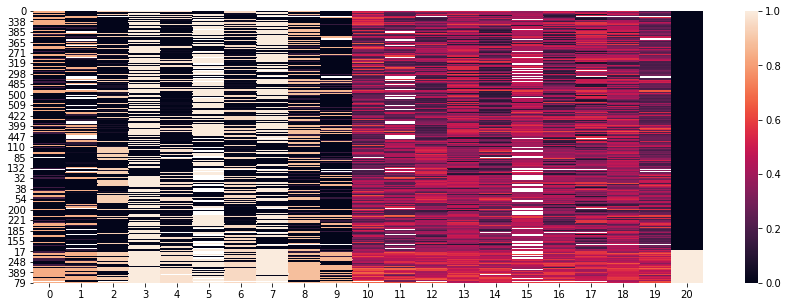

In [15]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 5]

sns.heatmap(pd.DataFrame(features).sort_values(by=20))

### Preenchimento 

Para valores vazios, preenchemos os valores de $X_{a,m}$ com a **moda** da coluna e os valores de $Y_{a,m}$ com a **média** da coluna.  

Esta média e esta moda são calculadas levando em conta somente os alunos de mesma classificação que o aluno ao qual pertence o valor vazio.

In [16]:

good = pd.DataFrame(features)
bad = pd.DataFrame(features)

good = good[good[20]==1]
bad = bad[bad[20]==0]

def nan_to_mode(table,modes):
    for idx, column in enumerate(table.columns):
        if idx < 10:
            table[column] = table[column].fillna(modes[idx])
        else:
            table[column] = table[column].fillna(table[column].mean())
    return table

modes = good.mode(dropna=True).iloc[0].values.tolist()
good = nan_to_mode(good, modes)
modes = bad.mode(dropna=True).iloc[0].values.tolist()
bad = nan_to_mode(bad, modes)

filled_features = list(good.values.tolist()) + list(bad.values.tolist())

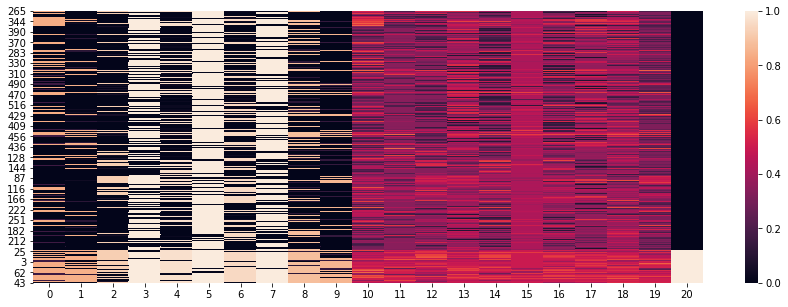

In [17]:
filled_plot = pd.DataFrame(filled_features)
sns.heatmap(filled_plot.sort_values(by=20))

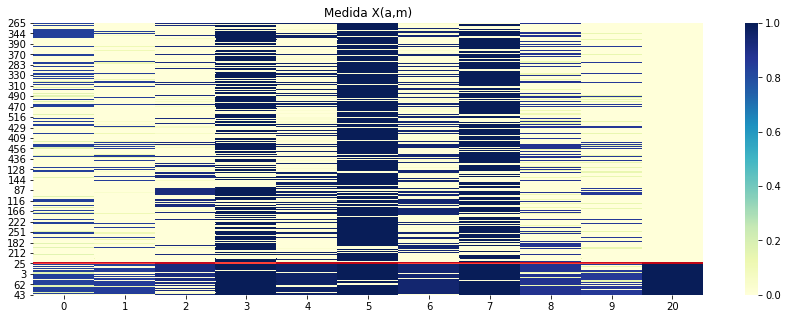

In [18]:
dataplot = pd.DataFrame(filled_features)\
            .dropna()\
            .sort_values(by=20)\
            [[0,1,2,3,4,5,6,7,8,9,20]]

border = dataplot[20].values.tolist()
frontier = [ i for i,v in enumerate(border) if i > 1 and border[i] != border[i-1]][0]

ax = sns.heatmap(dataplot, cmap="YlGnBu")
ax.hlines([frontier], colors=['red'], *ax.get_xlim())
ax.set_title("Medida X(a,m)")
pass

In [19]:
disciplinas['nome_componente'].reset_index()[['nome_componente']]

,nome_componente
0,CÁLCULO 1
1,LÓGICA MATEMÁTICA
2,MATEMÁTICA DISCRETA
3,FÍSICA PARA COMPUTAÇÃO
4,ÁLGEBRA LINEAR
5,CÁLCULO 2
6,PROGRAMAÇÃO DE COMPUTADORES 2 CN
7,SISTEMAS DIGITAIS
8,INTRODUÇÃO À COMPUTAÇÃO
9,PROGRAMAÇÃO DE COMPUTADORES 1 CN


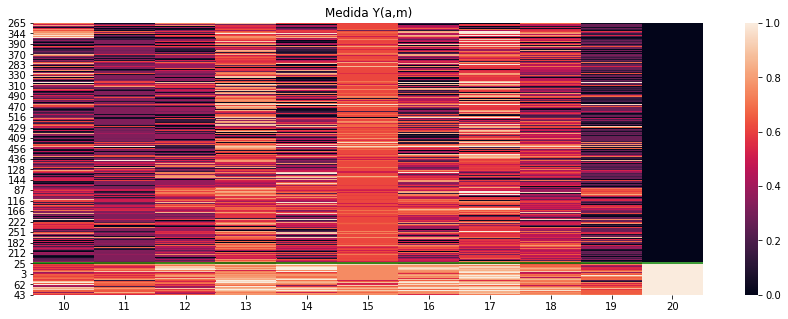

In [20]:
dataplot = pd.DataFrame(filled_features)\
            .dropna()\
            .sort_values(by=20)\
            [[10,11,12,13,14,15,16,17,18,19,20]]

for column in dataplot.columns:
    dataplot[column] = \
    (dataplot[column]-dataplot[column].min())/(dataplot[column].max()-dataplot[column].min())

border = dataplot[20].values.tolist()
border
frontier = [ i for i,v in enumerate(border) if i > 1 and border[i] != border[i-1]][0]

ax = sns.heatmap(dataplot)

ax.hlines([frontier], colors=['green'], *ax.get_xlim())
ax.set_title("Medida Y(a,m)")
pass

In [21]:
legend = disciplinas['nome_componente'].reset_index()[['nome_componente']]
legend.index = legend.index + 10
legend

,nome_componente
10,CÁLCULO 1
11,LÓGICA MATEMÁTICA
12,MATEMÁTICA DISCRETA
13,FÍSICA PARA COMPUTAÇÃO
14,ÁLGEBRA LINEAR
15,CÁLCULO 2
16,PROGRAMAÇÃO DE COMPUTADORES 2 CN
17,SISTEMAS DIGITAIS
18,INTRODUÇÃO À COMPUTAÇÃO
19,PROGRAMAÇÃO DE COMPUTADORES 1 CN


In [23]:
# Escrever os rows em ordem aleatória
write_dump = lambda x, y, h: x\
.sample(frac=1)\
.drop(columns=[2, 12])\
.to_csv(y, index=False, header=h)

cols = [0,1,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20]
dump = pd.DataFrame(filled_features)
write_dump(pd.DataFrame(filled_features), 'dataset.csv', cols)